# Homework 2: Anomaly Detection

### Imports

In [ ]:
# !pip install -r requirements.txt

In [1]:
!pip install -q lovely-tensors tensorboard wandb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.0 MB/s eta 0:00:00


In [2]:
!pip freeze > requirements.txt

In [ ]:
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter
import wandb



In [3]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [46]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

### Loading and preprocessing train data

In [6]:
drive.mount('/content/drive')

import os
train_folder_path = '/content/drive/MyDrive/dataset/train'
proliv_folder_path = '/content/drive/MyDrive/dataset/proliv'
test_folder_path = '/content/drive/MyDrive/dataset/test'

Mounted at /content/drive


In [7]:
# loading train data
images_train = []

for filename in os.listdir(train_folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(train_folder_path, filename)
        image = Image.open(img_path)
        images_train.append(np.array(image))

# loading proliv data
images_proliv = []

for filename in os.listdir(proliv_folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path_p = os.path.join(proliv_folder_path, filename)
        image_p = Image.open(img_path_p)
        images_proliv.append(np.array(image_p))



In [8]:
# create PyTorch dataset

class TrainDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]
        image = Image.fromarray(image)

        # Convert PIL image to RGB mode if it's not already
        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

# transform to tensor and normalise

transform = transforms.Compose([
    transforms.Resize((28, 49)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
# transform data and define dataloaders

train_dataset = TrainDataset(images_train, transform=transform)
proliv_dataset = TrainDataset(images_proliv, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
proliv_loader = DataLoader(proliv_dataset, batch_size=32, shuffle=True)

In [10]:
print(list(train_loader)[0].shape)
print(list(proliv_loader)[0].shape)

torch.Size([32, 3, 28, 49])
torch.Size([32, 3, 28, 49])


In [ ]:
# Show samples

def show_sample_images(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        axes[i].imshow(dataset[i])
        #axes[i].set_title(f"Class: normal")
        axes[i].axis('off')
    plt.show()

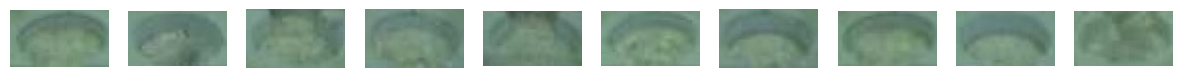

In [ ]:
show_sample_images(images_train, 10)

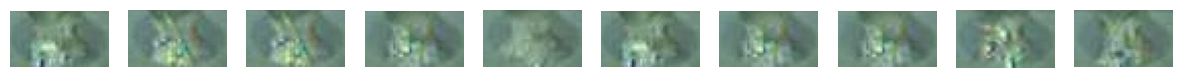

In [ ]:
show_sample_images(images_proliv, 10)

In [ ]:
image = cv2.imread(os.path.join(proliv_folder_path, filename))
print("The shape of the image is", image.shape)

The shape of the image is (28, 49, 3)


# Autoencoder setup

In [11]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, height, width, num_channels = 3):
        super(DenoisingAutoencoder, self).__init__()

        # Calculate input dimension
        self.input_dim = height * width * num_channels

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, self.input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Flatten input
        x = x.reshape(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        # Reshape output back
        return decoded.view(x.size(0), 3, height, width)



# Model training

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
batch_size, num_channels, height, width = list(train_loader)[0].shape
height

28

In [40]:
class AnomalyDetector:
    def __init__(self, device=device, height=height, width=width):
        self.device = device
        self.height = height
        self.width = width
        self.model = DenoisingAutoencoder(height, width).to(device)
        self.threshold = None

    def add_noise(self, x, noise_factor=0.3):
        noise = torch.randn_like(x) * noise_factor
        noisy = x + noise
        return torch.clip(noisy, 0., 1.)

    def train(self, train_loader, epochs=50, lr=1e-3):
        criterion = CombinedLoss(alpha=0.8) #nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        loss_history = []

        self.model.train()
        for epoch in tqdm(range(epochs)):
            total_loss = 0
            for batch in train_loader:
                x = batch.to(self.device)

                # Add noise to input
                z = self.add_noise(x)

                # Forward pass
                reconstructed = self.model(z)

                # Compute loss
                loss = criterion(reconstructed, x)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            loss_history.append(avg_loss)

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')

        # visualize
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(loss_history)), loss_history, label='Training Loss', color='blue')
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.xticks(range(len(loss_history)))
        plt.grid()
        plt.show()


    def set_threshold(self, proliv_loader, percentile=95):
        self.model.eval()
        errors = []

        with torch.no_grad():
            for batch in tqdm(proliv_loader):
                x = batch.to(self.device)
                #x = x.view(x.size(0), -1)
                reconstructed = self.model(x)
                error = torch.mean((x - reconstructed) ** 2, dim=(1,2,3)) #2,3
                errors.extend(error.cpu().numpy())

        self.threshold = np.mean(errors)
        print(f"Anomaly threshold set to: {self.threshold:.6f}")

    def detect(self, test_loader):
        if self.threshold is None:
            raise ValueError("Threshold not set. Call set_threshold() first.")

        self.model.eval()
        all_predictions = []
        all_labels = []
        all_mse = []
        all_reconstructed = []

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(self.device)
                reconstructed = self.model(images)
                mse = torch.mean((images - reconstructed) ** 2, dim=(1, 2, 3))
                predictions = (mse > self.threshold).cpu().numpy()

                all_predictions.extend(predictions)
                all_labels.extend(labels.cpu().numpy())
                all_mse.extend(mse.cpu().numpy())
                all_reconstructed.append(reconstructed.cpu())

        # Convert lists to numpy arrays
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)
        all_mse = np.array(all_mse)
        all_reconstructed = torch.cat(all_reconstructed, dim=0)

        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(all_labels, all_predictions).ravel()

        # Calculate TPR and TNR
        tpr = tp / (tp + fn)
        tnr = tn / (tn + fp)

        # Calculate other metrics
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * (precision * tpr) / (precision + tpr) if (precision + tpr) > 0 else 0

        results = {
            'predictions': all_predictions,
            'labels': all_labels,
            'reconstruction_errors': all_mse,
            'reconstructed_images': all_reconstructed,
            'metrics': {
                'true_positive_rate': tpr,
                'true_negative_rate': tnr,
                'accuracy': accuracy,
                'precision': precision,
                'f1_score': f1,
                'confusion_matrix': {
                    'tn': tn,
                    'fp': fp,
                    'fn': fn,
                    'tp': tp
                }
            }
        }

        # Print metrics
        print("\nEvaluation Metrics:")
        print(f"True Positive Rate (Sensitivity): {tpr:.4f}")
        print(f"True Negative Rate (Specificity): {tnr:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("\nConfusion Matrix:")
        print(f"True Negatives: {tn}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"True Positives: {tp}")

        return results

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/50], Loss: 0.012225
Epoch [20/50], Loss: 0.011282
Epoch [30/50], Loss: 0.010948
Epoch [40/50], Loss: 0.010814
Epoch [50/50], Loss: 0.010709


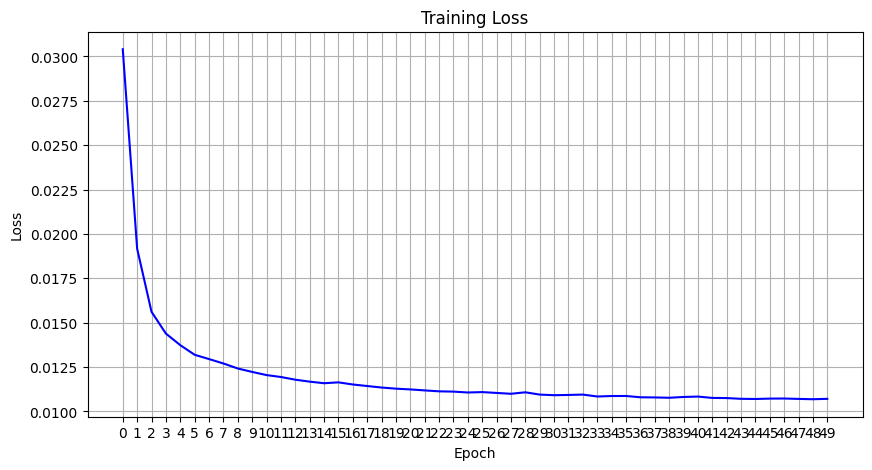

In [ ]:
detector = AnomalyDetector()
detector.train(train_loader, epochs=50)

In [ ]:
detector.set_threshold(proliv_loader) #percentile=95

  0%|          | 0/5 [00:00<?, ?it/s]

Anomaly threshold set to: 0.106169


# Evaluate baseline

### Loading test data

In [14]:
class TestDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = Image.fromarray(image)

        # Convert PIL image to RGB mode if it's not already
        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [15]:
# loading test data
data_txt_path = os.path.join(test_folder_path, 'test_annotation.txt')
data = pd.read_csv(data_txt_path, sep=' ', header=None)

images = []
labels = []

for index, row in tqdm(data.iterrows()):
    img_path = os.path.join(test_folder_path,'imgs/imgs', row[0])
    try:
        image = Image.open(img_path).resize((28, 49))
        images.append(np.array(image))
        labels.append(row[1])
    except FileNotFoundError:
        print(f"Warning: Image file not found: {img_path}")


0it [00:00, ?it/s]

In [16]:
# Convert to numpy arrays for easier manipulation
test_images = np.array(images)
test_labels = np.array(labels)

# Create a DataLoader for the test dataset
test_dataset = TestDataset(test_images, test_labels, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [20]:
# Data Analysis Functions
def analyze_class_distribution(dataset):
    labels = [sample[1] for sample in dataset]
    unique_labels, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=unique_labels, y=counts)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

    return dict(zip(unique_labels, counts))

def show_sample_images(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        axes[i].imshow(dataset[i]['image'])
        axes[i].set_title(f"Class: {dataset[i]['label']}")
        axes[i].axis('off')
    plt.show()


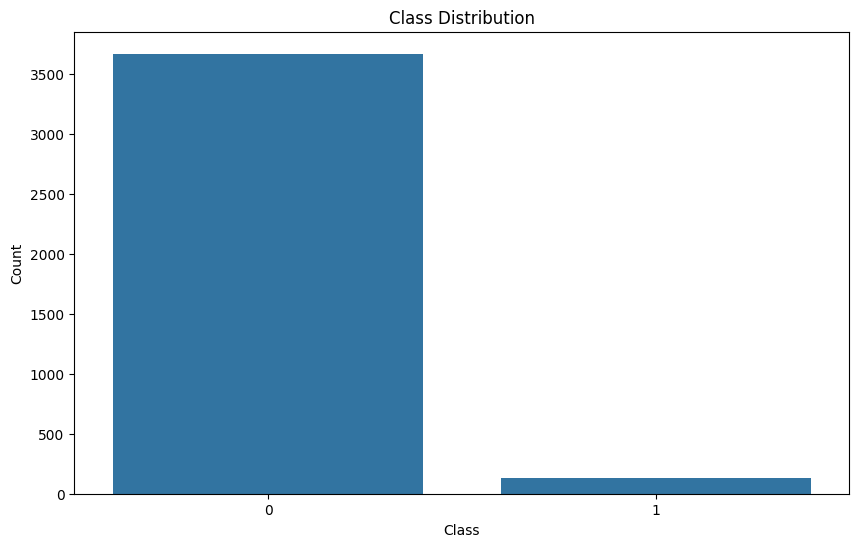

{0: 3665, 1: 129}

In [21]:
analyze_class_distribution(test_dataset)

### Evaluation

In [ ]:
# Evaluate on test dataset
results = detector.detect(test_loader)

# Access TPR and TNR
tpr = results['metrics']['true_positive_rate']
tnr = results['metrics']['true_negative_rate']


Evaluation Metrics:
True Positive Rate (Sensitivity): 0.4109
True Negative Rate (Specificity): 0.8903
Accuracy: 0.8740
Precision: 0.1165
F1 Score: 0.1815

Confusion Matrix:
True Negatives: 3263
False Positives: 402
False Negatives: 76
True Positives: 53


# Experiments

### Advanced threshold logic
Using both normal and anomalous validation data to find the optimal threshold:

The second approach is more robust because it:

- Uses both normal and anomalous samples
- Finds the threshold that best separates the two classes
- Can optimize for specific metrics (like F1 score)

In [22]:
from torch.utils.data import DataLoader, Subset

total_train_images = len(train_dataset)
selected_train_indices = torch.randperm(total_train_images)[:500]

# Create a subset of the dataset
train_subset = Subset(train_dataset, selected_train_indices)

total_proliv_images = len(proliv_dataset)
selected_proliv_indices = torch.randperm(total_proliv_images)[:500]  # Randomly select 500 unique indices

# Create a subset of the dataset
proliv_subset = Subset(proliv_dataset, selected_proliv_indices)


In [ ]:
proliv_subset[0].shape

torch.Size([3, 25, 40])

In [ ]:
num_channels, height, width = train_subset[0].shape

25

In [43]:
class AnomalyDetector1:
    def __init__(self, device=device, parameters=None, height=28, width=49):
        self.parameters = parameters
        self.device = device
        self.height = height
        self.width = width
        self.model = DenoisingAutoencoder(height, width).to(device)
        self.threshold = None

    def add_noise(self, x, noise_factor=0.3):
        noise = torch.randn_like(x) * noise_factor
        noisy = x + noise
        return torch.clip(noisy, 0., 1.)

    def train(self, train_loader, epochs=50, lr=1e-3):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        loss_history = []

        self.model.train()
        for epoch in tqdm(range(epochs)):
            total_loss = 0
            for batch in train_loader:
                x = batch.to(self.device)

                # Add noise to input
                z = self.add_noise(x)

                # Forward pass
                reconstructed = self.model(z)

                # Compute loss
                loss = criterion(reconstructed, x)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            loss_history.append(avg_loss)

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')

        # visualize
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(loss_history)), loss_history, label='Training Loss', color='blue')
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.xticks(range(len(loss_history)))
        plt.grid()
        plt.show()

    def set_optimal_threshold(self, normal_val_data, anomaly_val_data):
        """Find threshold that maximizes separation between normal and anomaly data"""
        self.model.eval()
        normal_errors = []
        anomaly_errors = []

        # Get reconstruction errors for normal data
        with torch.no_grad():
            for batch in DataLoader(normal_val_data, batch_size=32):
                x = batch.to(self.device)
                reconstructed = self.model(x)
                error = torch.mean((x - reconstructed) ** 2, dim=(1, 2, 3))
                normal_errors.extend(error.cpu().numpy())

        # Get reconstruction errors for anomalous data
        with torch.no_grad():
            for batch in DataLoader(anomaly_val_data, batch_size=32):
                x = batch.to(self.device)
                reconstructed = self.model(x)
                error = torch.mean((x - reconstructed) ** 2, dim=(1, 2, 3))
                anomaly_errors.extend(error.cpu().numpy())

        # Find threshold that maximizes separation
        all_errors = np.concatenate([normal_errors, anomaly_errors])
        all_labels = np.concatenate([np.zeros_like(normal_errors), np.ones_like(anomaly_errors)])

        best_f1 = 0
        best_threshold = 0

        for threshold in all_errors:
            predictions = (all_errors > threshold).astype(int)
            f1 = f1_score(all_labels, predictions)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        self.threshold = best_threshold
        print(f"Anomaly threshold set to: {self.threshold:.6f}")

    def detect(self, test_loader):
        if self.threshold is None:
            raise ValueError("Threshold not set. Call set_threshold() first.")

        self.model.eval()
        all_predictions = []
        all_labels = []
        all_mse = []
        all_reconstructed = []

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(self.device)
                reconstructed = self.model(images)
                mse = torch.mean((images - reconstructed) ** 2, dim=(1, 2, 3))
                predictions = (mse > self.threshold).cpu().numpy()

                all_predictions.extend(predictions)
                all_labels.extend(labels.cpu().numpy())
                all_mse.extend(mse.cpu().numpy())
                all_reconstructed.append(reconstructed.cpu())

        # Convert lists to numpy arrays
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)
        all_mse = np.array(all_mse)
        all_reconstructed = torch.cat(all_reconstructed, dim=0)

        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(all_labels, all_predictions).ravel()

        # Calculate TPR and TNR
        tpr = tp / (tp + fn)
        tnr = tn / (tn + fp)

        # Calculate other metrics
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * (precision * tpr) / (precision + tpr) if (precision + tpr) > 0 else 0

        results = {
            'predictions': all_predictions,
            'labels': all_labels,
            'reconstruction_errors': all_mse,
            'reconstructed_images': all_reconstructed,
            'metrics': {
                'true_positive_rate': tpr,
                'true_negative_rate': tnr,
                'accuracy': accuracy,
                'precision': precision,
                'f1_score': f1,
                'confusion_matrix': {
                    'tn': tn,
                    'fp': fp,
                    'fn': fn,
                    'tp': tp
                }
            }
        }

        # Print metrics
        print("\nEvaluation Metrics:")
        print(f"True Positive Rate (Sensitivity): {tpr:.4f}")
        print(f"True Negative Rate (Specificity): {tnr:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("\nConfusion Matrix:")
        print(f"True Negatives: {tn}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"True Positives: {tp}")

        return results

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

detector = AnomalyDetector1()
detector.set_optimal_threshold(train_subset, proliv_subset)

Anomaly threshold set to: 0.187403


In [ ]:
# Evaluate on test dataset
results = detector.detect(test_loader)

# Access TPR and TNR
tpr = results['metrics']['true_positive_rate']
tnr = results['metrics']['true_negative_rate']


Evaluation Metrics:
True Positive Rate (Sensitivity): 0.8837
True Negative Rate (Specificity): 0.6273
Accuracy: 0.6360
Precision: 0.0770
F1 Score: 0.1417

Confusion Matrix:
True Negatives: 2299
False Positives: 1366
False Negatives: 15
True Positives: 114


### Combined loss

In [24]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.8):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.mse = nn.MSELoss()
        self.l1 = nn.L1Loss()

    def forward(self, pred, target):
        mse_loss = self.mse(pred, target)
        l1_loss = self.l1(pred, target)
        return self.alpha * mse_loss + (1 - self.alpha) * l1_loss

In [38]:
def train_with_scheduler(model, train_loader, epochs=50, device=device):
    model_to_train = model.model
    criterion = CombinedLoss(alpha=0.8)
    optimizer = torch.optim.AdamW(model_to_train.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    loss_history = []

    for epoch in tqdm(range(epochs)):
        model_to_train.train()
        total_loss = 0

        for batch in train_loader:
            x = batch.to(device)
            optimizer.zero_grad()
            reconstructed = model_to_train(x)
            loss = criterion(reconstructed, x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        scheduler.step(avg_loss)
        loss_history.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')

    # visualize
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(loss_history)), loss_history, label='Training Loss', color='blue')
    plt.title('Training Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.xticks(range(len(loss_history)))
    plt.grid()
    plt.show()

    return model

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/50], Loss: 0.012489
Epoch [20/50], Loss: 0.011368
Epoch [30/50], Loss: 0.010983
Epoch [40/50], Loss: 0.010810
Epoch [50/50], Loss: 0.010701


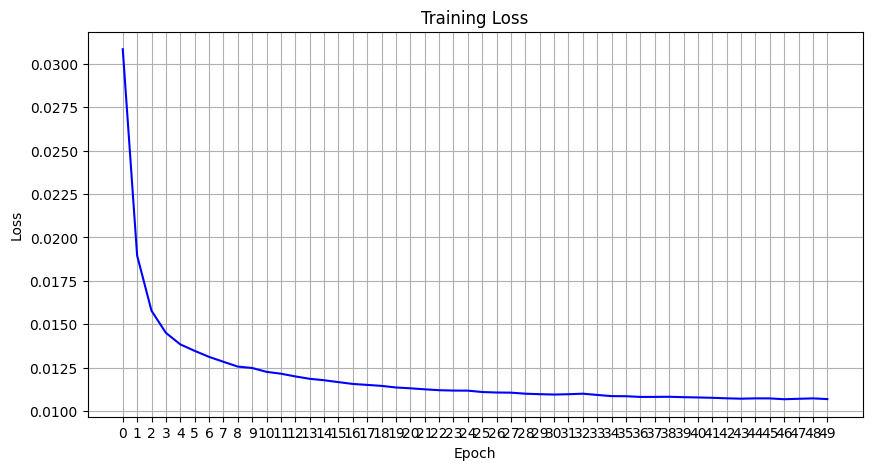

In [ ]:
detector = AnomalyDetector1()
detector.train(train_loader, epochs=50)

In [ ]:
detector.set_optimal_threshold(train_subset, proliv_subset)

Anomaly threshold set to: 0.079760


In [ ]:
# Evaluate on test dataset
results = detector.detect(test_loader)

# Access TPR and TNR
tpr = results['metrics']['true_positive_rate']
tnr = results['metrics']['true_negative_rate']


Evaluation Metrics:
True Positive Rate (Sensitivity): 0.7674
True Negative Rate (Specificity): 0.7858
Accuracy: 0.7852
Precision: 0.1120
F1 Score: 0.1955

Confusion Matrix:
True Negatives: 2880
False Positives: 785
False Negatives: 30
True Positives: 99


### Increase number of epochs

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/100], Loss: 0.012540
Epoch [20/100], Loss: 0.011387
Epoch [30/100], Loss: 0.011014
Epoch [40/100], Loss: 0.010833
Epoch [50/100], Loss: 0.010722
Epoch [60/100], Loss: 0.010687
Epoch [70/100], Loss: 0.010611
Epoch [80/100], Loss: 0.010569
Epoch [90/100], Loss: 0.010518
Epoch [100/100], Loss: 0.010524


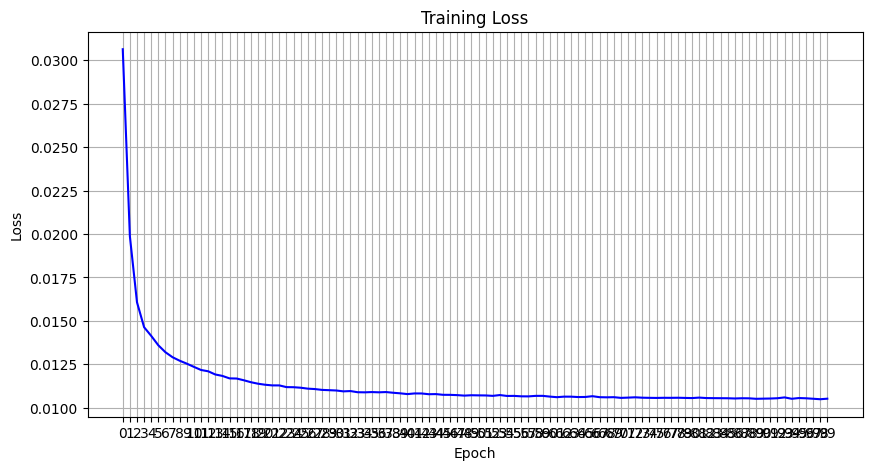

In [ ]:
detector = AnomalyDetector1()
detector.train(train_loader, epochs=100)

In [111]:
detector.set_optimal_threshold(train_subset, proliv_subset)

Anomaly threshold set to: 0.076927


In [112]:
# Evaluate on test dataset
results = detector.detect(test_loader)

# Access TPR and TNR
tpr = results['metrics']['true_positive_rate']
tnr = results['metrics']['true_negative_rate']


Evaluation Metrics:
True Positive Rate (Sensitivity): 0.7752
True Negative Rate (Specificity): 0.7261
Accuracy: 0.7277
Precision: 0.0906
F1 Score: 0.1622

Confusion Matrix:
True Negatives: 2661
False Positives: 1004
False Negatives: 29
True Positives: 100


### Number of epochs to 70

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch [10/70], Loss: 0.012550
Epoch [20/70], Loss: 0.011656
Epoch [30/70], Loss: 0.011262
Epoch [40/70], Loss: 0.011100
Epoch [50/70], Loss: 0.010933
Epoch [60/70], Loss: 0.010897
Epoch [70/70], Loss: 0.010841


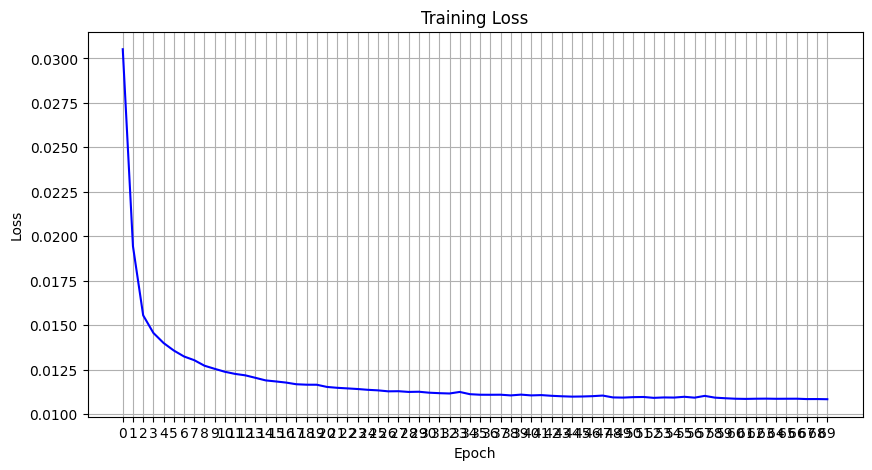

In [44]:
detector = AnomalyDetector1()
detector.train(train_loader, epochs=70)

In [47]:
detector.set_optimal_threshold(train_subset, proliv_subset)

Anomaly threshold set to: 0.085854


In [48]:
# Evaluate on test dataset
results = detector.detect(test_loader)

# Access TPR and TNR
tpr = results['metrics']['true_positive_rate']
tnr = results['metrics']['true_negative_rate']


Evaluation Metrics:
True Positive Rate (Sensitivity): 0.7829
True Negative Rate (Specificity): 0.8554
Accuracy: 0.8529
Precision: 0.1601
F1 Score: 0.2658

Confusion Matrix:
True Negatives: 3135
False Positives: 530
False Negatives: 28
True Positives: 101
